Classifications by number of days to trough:
days_within_2: 14.96%
days_within_5: 39.26%
days_within_10: 68.59%
days_within_20: 81.78%
days_within_50: 88.15%
days_within_200: 93.19%
days_within_500: 94.07%


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



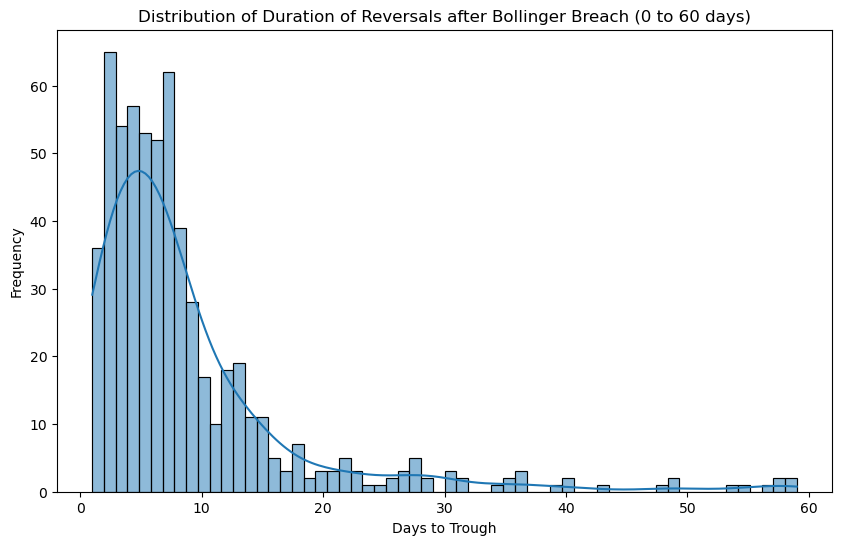

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



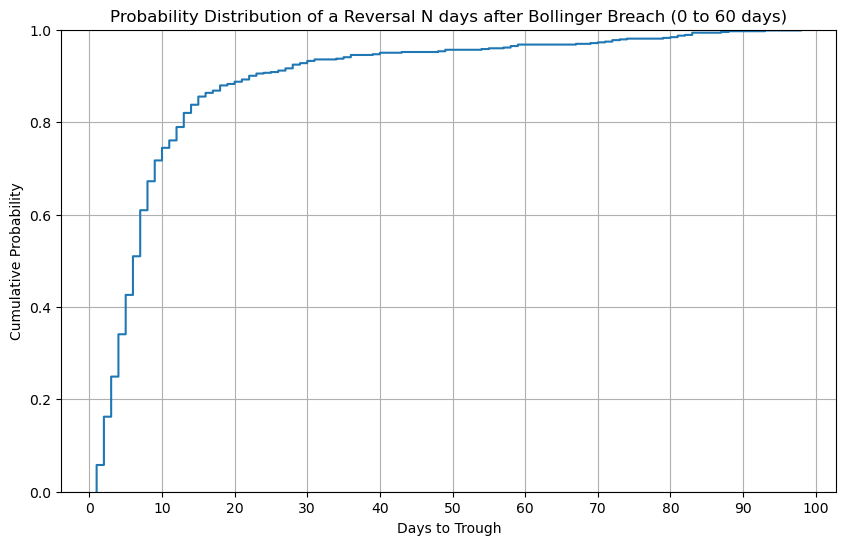

In [3]:
import yfinance as yf
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import plotly.offline as pyo

# Function to resample data to different time frames
def resample_data(data, time_frame):
    agg_dict = {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last'}
    return data.resample(time_frame).agg(agg_dict).dropna()

# Function to calculate SMA
def calculate_sma(data, window):
    return data['Close'].rolling(window=window).mean()

# Function to calculate Bollinger Bands
def calculate_bollinger_bands(data, window):
    sma = calculate_sma(data, window)
    std = data['Close'].rolling(window=window).std()
    upper_band = sma + (std * 2)
    lower_band = sma - (std * 2)
    return sma, upper_band, lower_band

# Function to calculate Parabolic SAR
def calculate_parabolic_sar(data):
    high = data['High'].values
    low = data['Low'].values
    close = data['Close'].values
    
    af = 0.02
    max_af = 0.2
    up_trend = True
    psar = np.zeros(len(close))
    ep = low[0]
    sar = high[0] - (high[0] - low[0]) * 0.02

    for i in range(1, len(close)):
        if up_trend:
            sar = sar + af * (ep - sar)
            psar[i] = sar

            if high[i] > ep:
                ep = high[i]
                af = min(af + 0.02, max_af)

            if low[i] < sar:
                up_trend = False
                sar = ep
                ep = low[i]
                af = 0.02
        else:
            sar = sar - af * (sar - ep)
            psar[i] = sar

            if low[i] < ep:
                ep = low[i]
                af = min(af + 0.02, max_af)

            if high[i] > sar:
                up_trend = True
                sar = ep
                ep = high[i]
                af = 0.02

    return psar

# Function to identify instances where the price exceeds the upper Bollinger Band and record subsequent price data
def identify_exceeding_bollinger(data):
    instances = []
    for i in range(len(data)):
        if data['High'].iloc[i] > data['Bollinger_Upper'].iloc[i]:
            instance_date = data.index[i]
            exceed_amount = data['High'].iloc[i] - data['Bollinger_Upper'].iloc[i]
            instances.append({
                'date': instance_date,
                'exceed_amount': exceed_amount,
                'Bollinger_Upper': data['Bollinger_Upper'].iloc[i]
            })
    return pd.DataFrame(instances)

# Function to create a combined curve using high points for bullish candles and low points for bearish candles
def create_combined_curve(data):
    combined_curve = []
    for i in range(len(data)):
        if data['Close'].iloc[i] > data['Open'].iloc[i]:  # Bullish candle
            combined_curve.append(data['High'].iloc[i])
        else:  # Bearish candle
            combined_curve.append(data['Low'].iloc[i])
    return np.array(combined_curve)

# Function to detect significant reversals using the combined curve and gradient method
def detect_reversals_with_gradient(data, combined_curve):
    gradient = np.gradient(combined_curve)
    reversals = []

    for i in range(1, len(gradient) - 1):
        if gradient[i-1] > 0 and gradient[i] < 0:  # Potential peak
            peak_value = combined_curve[i]
            peak_date = data.index[i]
            valid_trough_found = False
            for j in range(i+1, len(gradient)):
                if gradient[j-1] < 0 and gradient[j] > 0:  # Potential trough
                    trough_value = combined_curve[j]
                    trough_date = data.index[j]
                    if trough_value < peak_value:  # Ensure it's a valid trough
                        days_in_reversal = (trough_date - peak_date).days
                        drop_amount = peak_value - trough_value
                        reversals.append({
                            'peak_date': peak_date,
                            'trough_date': trough_date,
                            'peak_value': peak_value,
                            'trough_value': trough_value,
                            'drop_amount': drop_amount,
                            'days_in_reversal': days_in_reversal
                        })
                        valid_trough_found = True
                        break
            if not valid_trough_found:
                reversals.append({
                    'peak_date': peak_date,
                    'trough_date': None,
                    'peak_value': peak_value,
                    'trough_value': None,
                    'drop_amount': None,
                    'days_in_reversal': None
                })
    return pd.DataFrame(reversals)

# Function to match peaks above Bollinger Band with subsequent troughs
def match_peaks_with_troughs(exceeding_instances, reversals):
    results = []
    for i in range(len(exceeding_instances)):
        peak_date = exceeding_instances['date'].iloc[i]
        peak_value = exceeding_instances['exceed_amount'].iloc[i] + exceeding_instances['Bollinger_Upper'].iloc[i]
        matched_trough = None
        for j in range(len(reversals)):
            if reversals['peak_date'].iloc[j] >= peak_date:
                trough_date = reversals['trough_date'].iloc[j]
                if trough_date > peak_date:
                    drop_amount = peak_value - reversals['trough_value'].iloc[j]
                    if drop_amount >= 0:  # Ensure it's a valid drop
                        days_to_trough = (trough_date - peak_date).days
                        matched_trough = {
                            'peak_date': peak_date,
                            'trough_date': trough_date,
                            'peak_value': peak_value,
                            'trough_value': reversals['trough_value'].iloc[j],
                            'drop_amount': drop_amount,
                            'days_to_trough': days_to_trough
                        }
                        break
        if matched_trough is None:
            results.append({
                'peak_date': peak_date,
                'trough_date': None,
                'peak_value': peak_value,
                'trough_value': None,
                'drop_amount': None,
                'days_to_trough': None
            })
        else:
            results.append(matched_trough)
    return pd.DataFrame(results)

# Function to classify the results by the number of days to trough
def classify_results(results):
    bins = [2, 5, 10, 20, 50, 200, 500]
    classifications = {}
    for b in bins:
        classifications[f'days_within_{b}'] = len(results[results['days_to_trough'] <= b])
    total_instances = len(results)
    for key in classifications:
        classifications[key] = (classifications[key] / total_instances) * 100  # Convert to percentage
    return classifications

# Fetch data from Yahoo Finance
data = yf.download('NQ=F', start='1999-01-01', progress=False)

# Ensure the data only includes trading days
data = data.dropna()

# Resample data to weekly and monthly
weekly_data = resample_data(data, 'W-FRI')
monthly_data = resample_data(data, 'M')

# Calculate indicators for daily data
data['SMA_20'] = calculate_sma(data, 20)
data['SMA_50'] = calculate_sma(data, 50)
data['SMA_100'] = calculate_sma(data, 100)
data['Bollinger_Mid'], data['Bollinger_Upper'], data['Bollinger_Lower'] = calculate_bollinger_bands(data, 20)
data['Parabolic_SAR'] = calculate_parabolic_sar(data)

# Calculate indicators for weekly data
weekly_data['SMA_20'] = calculate_sma(weekly_data, 20)
weekly_data['SMA_50'] = calculate_sma(weekly_data, 50)
weekly_data['SMA_100'] = calculate_sma(weekly_data, 100)
weekly_data['Bollinger_Mid'], weekly_data['Bollinger_Upper'], weekly_data['Bollinger_Lower'] = calculate_bollinger_bands(weekly_data, 20)
weekly_data['Parabolic_SAR'] = calculate_parabolic_sar(weekly_data)

# Calculate indicators for monthly data
monthly_data['SMA_20'] = calculate_sma(monthly_data, 20)
monthly_data['SMA_50'] = calculate_sma(monthly_data, 50)
monthly_data['SMA_100'] = calculate_sma(monthly_data, 100)
monthly_data['Bollinger_Mid'], monthly_data['Bollinger_Upper'], monthly_data['Bollinger_Lower'] = calculate_bollinger_bands(monthly_data, 20)
monthly_data['Parabolic_SAR'] = calculate_parabolic_sar(monthly_data)

# Identify instances where price exceeds upper Bollinger Band
exceeding_instances = identify_exceeding_bollinger(data)

# Create the combined curve
combined_curve = create_combined_curve(data)

# Detect significant reversals using the gradient method
reversals = detect_reversals_with_gradient(data, combined_curve)

# Match peaks above Bollinger Band with subsequent troughs
matched_troughs = match_peaks_with_troughs(exceeding_instances, reversals)

# Classify the results by the number of days to trough
classifications = classify_results(matched_troughs)

# Print classifications
print("Classifications by number of days to trough:")
for key, value in classifications.items():
    print(f"{key}: {value:.2f}%")

# Save the instances and reversals for further analysis
csv_file_exceeding = 'exceeding_bollinger_instances.csv'
csv_file_reversals = 'significant_reversals.csv'
csv_file_matched_reversals = 'matched_reversals.csv'
exceeding_instances.to_csv(csv_file_exceeding, index=False)
reversals.to_csv(csv_file_reversals, index=False)
matched_troughs.to_csv(csv_file_matched_reversals, index=False)

# Define start and end dates for daily, weekly, and monthly data display
end_date = datetime.now()
start_date_daily = end_date - timedelta(days=365)
start_date_weekly = end_date - timedelta(days=2*365)
start_date_monthly = end_date - timedelta(days=10*365)

# Function to calculate y-axis range with margin
def calculate_y_range(data, start_date, end_date, margin=0.05):
    data_range = data[(data.index >= start_date) & (data.index <= end_date)]
    y_min = data_range['Low'].min()
    y_max = data_range['High'].max()
    y_margin = (y_max - y_min) * margin
    return [y_min - y_margin, y_max + y_margin]

# Calculate initial y-axis range for daily data
initial_y_range = calculate_y_range(data, start_date_daily, end_date)

# Initialize the figure
fig = go.Figure()

# Add traces for daily, weekly, and monthly data with SMA
fig.add_trace(go.Candlestick(x=data.index,
                             open=data['Open'],
                             high=data['High'],
                             low=data['Low'],
                             close=data['Close'],
                             name='Daily Candlestick',
                             visible=True))  # Initially visible

fig.add_trace(go.Candlestick(x=weekly_data.index,
                             open=weekly_data['Open'],
                             high=weekly_data['High'],
                             low=weekly_data['Low'],
                             close=weekly_data['Close'],
                             name='Weekly Candlestick',
                             visible=False))  # Initially hidden

fig.add_trace(go.Candlestick(x=monthly_data.index,
                             open=monthly_data['Open'],
                             high=monthly_data['High'],
                             low=monthly_data['Low'],
                             close=monthly_data['Close'],
                             name='Monthly Candlestick',
                             visible=False))  # Initially hidden

# Add SMA traces for daily data
fig.add_trace(go.Scatter(x=data.index, y=data['SMA_20'], mode='lines', name='Daily SMA 20', visible=True, line=dict(color='blue')))
fig.add_trace(go.Scatter(x=data.index, y=data['SMA_50'], mode='lines', name='Daily SMA 50', visible=True, line=dict(color='green')))
fig.add_trace(go.Scatter(x=data.index, y=data['SMA_100'], mode='lines', name='Daily SMA 100', visible=True, line=dict(color='red')))

# Add Bollinger Bands for daily data
fig.add_trace(go.Scatter(x=data.index, y=data['Bollinger_Upper'], mode='lines', name='Daily Bollinger Upper', visible=True, line=dict(color='magenta')))
fig.add_trace(go.Scatter(x=data.index, y=data['Bollinger_Lower'], mode='lines', name='Daily Bollinger Lower', visible=True, line=dict(color='magenta')))
fig.add_trace(go.Scatter(x=data.index, y=data['Bollinger_Mid'], mode='lines', name='Daily Bollinger Mid', visible=True, line=dict(color='cyan')))

# Add Parabolic SAR for daily data
fig.add_trace(go.Scatter(x=data.index, y=data['Parabolic_SAR'], mode='markers', name='Daily Parabolic SAR', visible=True, marker=dict(color='black', size=4)))

# Add SMA traces for weekly data
fig.add_trace(go.Scatter(x=weekly_data.index, y=weekly_data['SMA_20'], mode='lines', name='Weekly SMA 20', visible=False, line=dict(color='blue')))
fig.add_trace(go.Scatter(x=weekly_data.index, y=weekly_data['SMA_50'], mode='lines', name='Weekly SMA 50', visible=False, line=dict(color='green')))
fig.add_trace(go.Scatter(x=weekly_data.index, y=weekly_data['SMA_100'], mode='lines', name='Weekly SMA 100', visible=False, line=dict(color='red')))

# Add Bollinger Bands for weekly data
fig.add_trace(go.Scatter(x=weekly_data.index, y=weekly_data['Bollinger_Upper'], mode='lines', name='Weekly Bollinger Upper', visible=False, line=dict(color='magenta')))
fig.add_trace(go.Scatter(x=weekly_data.index, y=weekly_data['Bollinger_Lower'], mode='lines', name='Weekly Bollinger Lower', visible=False, line=dict(color='magenta')))
fig.add_trace(go.Scatter(x=weekly_data.index, y=weekly_data['Bollinger_Mid'], mode='lines', name='Weekly Bollinger Mid', visible=False, line=dict(color='cyan')))

# Add Parabolic SAR for weekly data
fig.add_trace(go.Scatter(x=weekly_data.index, y=weekly_data['Parabolic_SAR'], mode='markers', name='Weekly Parabolic SAR', visible=False, marker=dict(color='black', size=4)))

# Add SMA traces for monthly data
fig.add_trace(go.Scatter(x=monthly_data.index, y=monthly_data['SMA_20'], mode='lines', name='Monthly SMA 20', visible=False, line=dict(color='blue')))
fig.add_trace(go.Scatter(x=monthly_data.index, y=monthly_data['SMA_50'], mode='lines', name='Monthly SMA 50', visible=False, line=dict(color='green')))
fig.add_trace(go.Scatter(x=monthly_data.index, y=monthly_data['SMA_100'], mode='lines', name='Monthly SMA 100', visible=False, line=dict(color='red')))

# Add Bollinger Bands for monthly data
fig.add_trace(go.Scatter(x=monthly_data.index, y=monthly_data['Bollinger_Upper'], mode='lines', name='Monthly Bollinger Upper', visible=False, line=dict(color='magenta')))
fig.add_trace(go.Scatter(x=monthly_data.index, y=monthly_data['Bollinger_Lower'], mode='lines', name='Monthly Bollinger Lower', visible=False, line=dict(color='magenta')))
fig.add_trace(go.Scatter(x=monthly_data.index, y=monthly_data['Bollinger_Mid'], mode='lines', name='Monthly Bollinger Mid', visible=False, line=dict(color='cyan')))

# Add Parabolic SAR for monthly data
fig.add_trace(go.Scatter(x=monthly_data.index, y=monthly_data['Parabolic_SAR'], mode='markers', name='Monthly Parabolic SAR', visible=False, marker=dict(color='black', size=4)))

# Add combined curve
fig.add_trace(go.Scatter(x=data.index, y=combined_curve, mode='lines', name='Combined Curve', line=dict(color='orange')))

# Add matched troughs
for _, row in matched_troughs.iterrows():
    if pd.notnull(row['trough_date']):
        fig.add_trace(go.Scatter(x=[row['peak_date'], row['trough_date']],
                                 y=[row['peak_value'], row['trough_value']],
                                 mode='lines+markers',
                                 line=dict(color='red', dash='dash'),
                                 marker=dict(color='red'),
                                 name=f"Drop {row['drop_amount']} points over {row['days_to_trough']} days"))

# Update layout to include buttons for interactivity and reset view
fig.update_layout(
    title='NASDAQ Index Data Since 1999 with SMA, Bollinger Bands, and Parabolic SAR',
    xaxis_title='Date',
    yaxis_title='Price',
    dragmode='zoom',
    xaxis_rangeslider_visible=True,
    yaxis=dict(fixedrange=False, range=initial_y_range),
    width=1200,
    height=800,
    xaxis=dict(range=[start_date_daily, end_date]),
    updatemenus=[
        dict(
            type="buttons",
            direction="left",
            x=0.5,
            xanchor="center",
            y=1.05,
            yanchor="top",
            buttons=list([
                dict(
                    args=[{"visible": [True, False, False, True, True, True, True, True, True, True, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]},
                          {"xaxis.range": [start_date_daily, end_date], "yaxis.range": calculate_y_range(data, start_date_daily, end_date)}],
                    label="Daily",
                    method="update"
                ),
                dict(
                    args=[{"visible": [False, True, False, False, False, False, False, False, False, False, True, True, True, True, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]},
                          {"yaxis.range": calculate_y_range(weekly_data, start_date_weekly, end_date)}],
                    label="Weekly",
                    method="update"
                ),
                dict(
                    args=[{"visible": [False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, True, True, True, True, False, False, False, False, False, False, False, False, False]},
                          {"yaxis.range": calculate_y_range(monthly_data, start_date_monthly, end_date)}],
                    label="Monthly",
                    method="update"
                ),
                dict(
                    args=[{"xaxis.autorange": True, "yaxis.autorange": True}],
                    label="Reset View",
                    method="relayout"
                )
            ]),
        )
    ]
)

# Save the figure to an HTML file and open it in a web browser
pyo.plot(fig, filename='nasdaq_chart.html')

import seaborn as sns
import matplotlib.pyplot as plt

# Load the matched troughs data
matched_troughs = pd.read_csv('matched_reversals.csv')

# Filter out rows with None values for 'days_to_trough' and only include days from 0 to 60
matched_troughs_filtered = matched_troughs.dropna(subset=['days_to_trough'])
matched_troughs_filtered = matched_troughs_filtered[matched_troughs_filtered['days_to_trough'] <= 60]

# Plot the distribution of 'days_to_trough'
plt.figure(figsize=(10, 6))
sns.histplot(matched_troughs_filtered['days_to_trough'], bins=60, kde=True)
plt.title('Distribution of Duration of Reversals after Bollinger Breach (0 to 60 days)')
plt.xlabel('Days to Trough')
plt.ylabel('Frequency')
plt.show()


import seaborn as sns
import matplotlib.pyplot as plt

# Load the matched troughs data
matched_troughs = pd.read_csv('matched_reversals.csv')

# Filter out rows with None values for 'days_to_trough' and only include days from 0 to 100
matched_troughs_filtered = matched_troughs.dropna(subset=['days_to_trough'])
matched_troughs_filtered = matched_troughs_filtered[matched_troughs_filtered['days_to_trough'] <= 100]

# Plot the cumulative distribution of 'days_to_trough'
plt.figure(figsize=(10, 6))
sns.ecdfplot(matched_troughs_filtered['days_to_trough'])
plt.title('Probability Distribution of a Reversal N days after Bollinger Breach (0 to 60 days)')
plt.xlabel('Days to Trough')
plt.ylabel('Cumulative Probability')
plt.xticks(np.arange(0, 101, 10))  # Set x-axis ticks to have more divisions
plt.grid(True)
plt.show()


Classifications by number of days to trough:
days_within_2: 14.96%
days_within_5: 39.26%
days_within_10: 68.59%
days_within_20: 81.78%
days_within_50: 88.15%
days_within_200: 93.19%
days_within_500: 94.07%


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



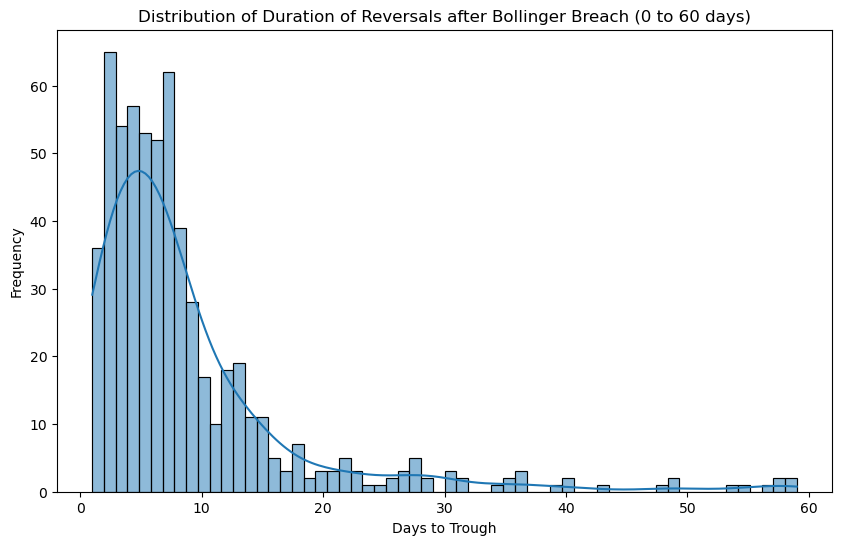

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



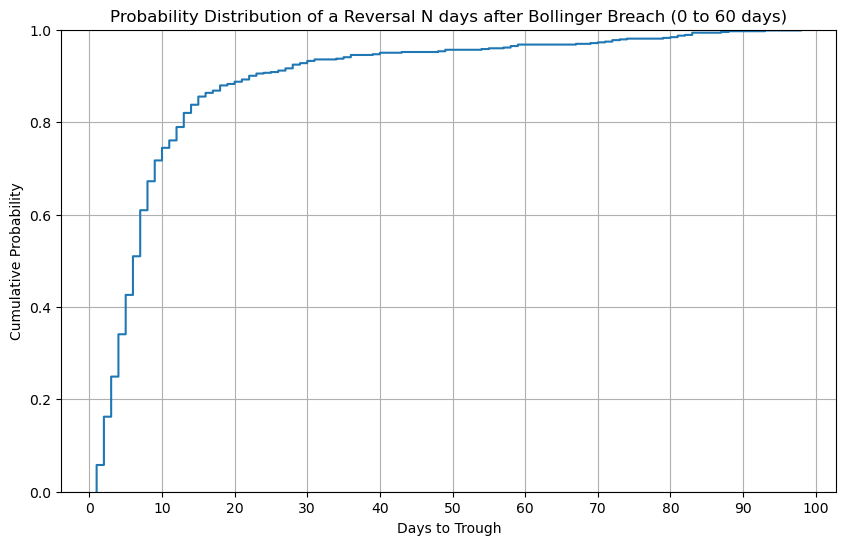

In [5]:
import yfinance as yf
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import plotly.offline as pyo
import seaborn as sns
import matplotlib.pyplot as plt

# Function to resample data to different time frames
def resample_data(data, time_frame):
    agg_dict = {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last'}
    return data.resample(time_frame).agg(agg_dict).dropna()

# Function to calculate SMA
def calculate_sma(data, window):
    return data['Close'].rolling(window=window).mean()

# Function to calculate Bollinger Bands
def calculate_bollinger_bands(data, window):
    sma = calculate_sma(data, window)
    std = data['Close'].rolling(window=window).std()
    upper_band = sma + (std * 2)
    lower_band = sma - (std * 2)
    return sma, upper_band, lower_band

# Function to calculate Parabolic SAR
def calculate_parabolic_sar(data):
    high = data['High'].values
    low = data['Low'].values
    close = data['Close'].values
    
    af = 0.02
    max_af = 0.2
    up_trend = True
    psar = np.zeros(len(close))
    ep = low[0]
    sar = high[0] - (high[0] - low[0]) * 0.02

    for i in range(1, len(close)):
        if up_trend:
            sar = sar + af * (ep - sar)
            psar[i] = sar

            if high[i] > ep:
                ep = high[i]
                af = min(af + 0.02, max_af)

            if low[i] < sar:
                up_trend = False
                sar = ep
                ep = low[i]
                af = 0.02
        else:
            sar = sar - af * (sar - ep)
            psar[i] = sar

            if low[i] < ep:
                ep = low[i]
                af = min(af + 0.02, max_af)

            if high[i] > sar:
                up_trend = True
                sar = ep
                ep = high[i]
                af = 0.02

    return psar

# Function to identify instances where the price exceeds the upper Bollinger Band and record subsequent price data
def identify_exceeding_bollinger(data):
    instances = []
    for i in range(len(data)):
        if data['High'].iloc[i] > data['Bollinger_Upper'].iloc[i]:
            instance_date = data.index[i]
            exceed_amount = data['High'].iloc[i] - data['Bollinger_Upper'].iloc[i]
            instances.append({
                'date': instance_date,
                'exceed_amount': exceed_amount,
                'Bollinger_Upper': data['Bollinger_Upper'].iloc[i]
            })
    return pd.DataFrame(instances)

# Function to create a combined curve using high points for bullish candles and low points for bearish candles
def create_combined_curve(data):
    combined_curve = []
    for i in range(len(data)):
        if data['Close'].iloc[i] > data['Open'].iloc[i]:  # Bullish candle
            combined_curve.append(data['High'].iloc[i])
        else:  # Bearish candle
            combined_curve.append(data['Low'].iloc[i])
    return np.array(combined_curve)

# Function to detect significant reversals using the combined curve and gradient method
def detect_reversals_with_gradient(data, combined_curve):
    gradient = np.gradient(combined_curve)
    reversals = []

    for i in range(1, len(gradient) - 1):
        if gradient[i-1] > 0 and gradient[i] < 0:  # Potential peak
            peak_value = combined_curve[i]
            peak_date = data.index[i]
            valid_trough_found = False
            for j in range(i+1, len(gradient)):
                if gradient[j-1] < 0 and gradient[j] > 0:  # Potential trough
                    trough_value = combined_curve[j]
                    trough_date = data.index[j]
                    if trough_value < peak_value:  # Ensure it's a valid trough
                        days_in_reversal = (trough_date - peak_date).days
                        drop_amount = peak_value - trough_value
                        reversals.append({
                            'peak_date': peak_date,
                            'trough_date': trough_date,
                            'peak_value': peak_value,
                            'trough_value': trough_value,
                            'drop_amount': drop_amount,
                            'days_in_reversal': days_in_reversal
                        })
                        valid_trough_found = True
                        break
            if not valid_trough_found:
                reversals.append({
                    'peak_date': peak_date,
                    'trough_date': None,
                    'peak_value': peak_value,
                    'trough_value': None,
                    'drop_amount': None,
                    'days_in_reversal': None
                })
    return pd.DataFrame(reversals)

# Function to match peaks above Bollinger Band with subsequent troughs
def match_peaks_with_troughs(exceeding_instances, reversals):
    results = []
    for i in range(len(exceeding_instances)):
        peak_date = exceeding_instances['date'].iloc[i]
        peak_value = exceeding_instances['exceed_amount'].iloc[i] + exceeding_instances['Bollinger_Upper'].iloc[i]
        matched_trough = None
        for j in range(len(reversals)):
            if reversals['peak_date'].iloc[j] >= peak_date:
                trough_date = reversals['trough_date'].iloc[j]
                if trough_date > peak_date:
                    drop_amount = peak_value - reversals['trough_value'].iloc[j]
                    if drop_amount >= 0:  # Ensure it's a valid drop
                        days_to_trough = (trough_date - peak_date).days
                        matched_trough = {
                            'peak_date': peak_date,
                            'trough_date': trough_date,
                            'peak_value': peak_value,
                            'trough_value': reversals['trough_value'].iloc[j],
                            'drop_amount': drop_amount,
                            'days_to_trough': days_to_trough
                        }
                        break
        if matched_trough is None:
            results.append({
                'peak_date': peak_date,
                'trough_date': None,
                'peak_value': peak_value,
                'trough_value': None,
                'drop_amount': None,
                'days_to_trough': None
            })
        else:
            results.append(matched_trough)
    return pd.DataFrame(results)

# Function to classify the results by the number of days to trough
def classify_results(results):
    bins = [2, 5, 10, 20, 50, 200, 500]
    classifications = {}
    for b in bins:
        classifications[f'days_within_{b}'] = len(results[results['days_to_trough'] <= b])
    total_instances = len(results)
    for key in classifications:
        classifications[key] = (classifications[key] / total_instances) * 100  # Convert to percentage
    return classifications

# Fetch data from Yahoo Finance
data = yf.download('NQ=F', start='1999-01-01', progress=False)

# Ensure the data only includes trading days
data = data.dropna()

# Resample data to weekly and monthly
weekly_data = resample_data(data, 'W-FRI')
monthly_data = resample_data(data, 'M')

# Calculate indicators for daily data
data['SMA_20'] = calculate_sma(data, 20)
data['SMA_50'] = calculate_sma(data, 50)
data['SMA_100'] = calculate_sma(data, 100)
data['Bollinger_Mid'], data['Bollinger_Upper'], data['Bollinger_Lower'] = calculate_bollinger_bands(data, 20)
data['Parabolic_SAR'] = calculate_parabolic_sar(data)

# Calculate indicators for weekly data
weekly_data['SMA_20'] = calculate_sma(weekly_data, 20)
weekly_data['SMA_50'] = calculate_sma(weekly_data, 50)
weekly_data['SMA_100'] = calculate_sma(weekly_data, 100)
weekly_data['Bollinger_Mid'], weekly_data['Bollinger_Upper'], weekly_data['Bollinger_Lower'] = calculate_bollinger_bands(weekly_data, 20)
weekly_data['Parabolic_SAR'] = calculate_parabolic_sar(weekly_data)

# Calculate indicators for monthly data
monthly_data['SMA_20'] = calculate_sma(monthly_data, 20)
monthly_data['SMA_50'] = calculate_sma(monthly_data, 50)
monthly_data['SMA_100'] = calculate_sma(monthly_data, 100)
monthly_data['Bollinger_Mid'], monthly_data['Bollinger_Upper'], monthly_data['Bollinger_Lower'] = calculate_bollinger_bands(monthly_data, 20)
monthly_data['Parabolic_SAR'] = calculate_parabolic_sar(monthly_data)

# Identify instances where price exceeds upper Bollinger Band
exceeding_instances = identify_exceeding_bollinger(data)

# Create the combined curve
combined_curve = create_combined_curve(data)

# Detect significant reversals using the gradient method
reversals = detect_reversals_with_gradient(data, combined_curve)

# Match peaks above Bollinger Band with subsequent troughs
matched_troughs = match_peaks_with_troughs(exceeding_instances, reversals)

# Classify the results by the number of days to trough
classifications = classify_results(matched_troughs)

# Print classifications
print("Classifications by number of days to trough:")
for key, value in classifications.items():
    print(f"{key}: {value:.2f}%")

# Save the instances and reversals for further analysis
csv_file_exceeding = 'exceeding_bollinger_instances.csv'
csv_file_reversals = 'significant_reversals.csv'
csv_file_matched_reversals = 'matched_reversals.csv'
exceeding_instances.to_csv(csv_file_exceeding, index=False)
reversals.to_csv(csv_file_reversals, index=False)
matched_troughs.to_csv(csv_file_matched_reversals, index=False)

# Define start and end dates for daily, weekly, and monthly data display
end_date = datetime.now()
start_date_daily = end_date - timedelta(days=365)
start_date_weekly = end_date - timedelta(days=2*365)
start_date_monthly = end_date - timedelta(days=10*365)

# Function to calculate y-axis range with margin
def calculate_y_range(data, start_date, end_date, margin=0.05):
    data_range = data[(data.index >= start_date) & (data.index <= end_date)]
    y_min = data_range['Low'].min()
    y_max = data_range['High'].max()
    y_margin = (y_max - y_min) * margin
    return [y_min - y_margin, y_max + y_margin]

# Calculate initial y-axis range for daily data
initial_y_range = calculate_y_range(data, start_date_daily, end_date)

# Initialize the figure
fig = go.Figure()

# Add traces for daily, weekly, and monthly data with SMA
fig.add_trace(go.Candlestick(x=data.index,
                             open=data['Open'],
                             high=data['High'],
                             low=data['Low'],
                             close=data['Close'],
                             name='Daily Candlestick',
                             visible=True))  # Initially visible

fig.add_trace(go.Candlestick(x=weekly_data.index,
                             open=weekly_data['Open'],
                             high=weekly_data['High'],
                             low=weekly_data['Low'],
                             close=weekly_data['Close'],
                             name='Weekly Candlestick',
                             visible=False))  # Initially hidden

fig.add_trace(go.Candlestick(x=monthly_data.index,
                             open=monthly_data['Open'],
                             high=monthly_data['High'],
                             low=monthly_data['Low'],
                             close=monthly_data['Close'],
                             name='Monthly Candlestick',
                             visible=False))  # Initially hidden

# Add SMA traces for daily data
fig.add_trace(go.Scatter(x=data.index, y=data['SMA_20'], mode='lines', name='Daily SMA 20', visible=True, line=dict(color='blue')))
fig.add_trace(go.Scatter(x=data.index, y=data['SMA_50'], mode='lines', name='Daily SMA 50', visible=True, line=dict(color='green')))
fig.add_trace(go.Scatter(x=data.index, y=data['SMA_100'], mode='lines', name='Daily SMA 100', visible=True, line=dict(color='red')))

# Add Bollinger Bands for daily data
fig.add_trace(go.Scatter(x=data.index, y=data['Bollinger_Upper'], mode='lines', name='Daily Bollinger Upper', visible=True, line=dict(color='magenta')))
fig.add_trace(go.Scatter(x=data.index, y=data['Bollinger_Lower'], mode='lines', name='Daily Bollinger Lower', visible=True, line=dict(color='magenta')))
fig.add_trace(go.Scatter(x=data.index, y=data['Bollinger_Mid'], mode='lines', name='Daily Bollinger Mid', visible=True, line=dict(color='cyan')))

# Add Parabolic SAR for daily data
fig.add_trace(go.Scatter(x=data.index, y=data['Parabolic_SAR'], mode='markers', name='Daily Parabolic SAR', visible=True, marker=dict(color='black', size=4)))

# Add SMA traces for weekly data
fig.add_trace(go.Scatter(x=weekly_data.index, y=weekly_data['SMA_20'], mode='lines', name='Weekly SMA 20', visible=False, line=dict(color='blue')))
fig.add_trace(go.Scatter(x=weekly_data.index, y=weekly_data['SMA_50'], mode='lines', name='Weekly SMA 50', visible=False, line=dict(color='green')))
fig.add_trace(go.Scatter(x=weekly_data.index, y=weekly_data['SMA_100'], mode='lines', name='Weekly SMA 100', visible=False, line=dict(color='red')))

# Add Bollinger Bands for weekly data
fig.add_trace(go.Scatter(x=weekly_data.index, y=weekly_data['Bollinger_Upper'], mode='lines', name='Weekly Bollinger Upper', visible=False, line=dict(color='magenta')))
fig.add_trace(go.Scatter(x=weekly_data.index, y=weekly_data['Bollinger_Lower'], mode='lines', name='Weekly Bollinger Lower', visible=False, line=dict(color='magenta')))
fig.add_trace(go.Scatter(x=weekly_data.index, y=weekly_data['Bollinger_Mid'], mode='lines', name='Weekly Bollinger Mid', visible=False, line=dict(color='cyan')))

# Add Parabolic SAR for weekly data
fig.add_trace(go.Scatter(x=weekly_data.index, y=weekly_data['Parabolic_SAR'], mode='markers', name='Weekly Parabolic SAR', visible=False, marker=dict(color='black', size=4)))

# Add SMA traces for monthly data
fig.add_trace(go.Scatter(x=monthly_data.index, y=monthly_data['SMA_20'], mode='lines', name='Monthly SMA 20', visible=False, line=dict(color='blue')))
fig.add_trace(go.Scatter(x=monthly_data.index, y=monthly_data['SMA_50'], mode='lines', name='Monthly SMA 50', visible=False, line=dict(color='green')))
fig.add_trace(go.Scatter(x=monthly_data.index, y=monthly_data['SMA_100'], mode='lines', name='Monthly SMA 100', visible=False, line=dict(color='red')))

# Add Bollinger Bands for monthly data
fig.add_trace(go.Scatter(x=monthly_data.index, y=monthly_data['Bollinger_Upper'], mode='lines', name='Monthly Bollinger Upper', visible=False, line=dict(color='magenta')))
fig.add_trace(go.Scatter(x=monthly_data.index, y=monthly_data['Bollinger_Lower'], mode='lines', name='Monthly Bollinger Lower', visible=False, line=dict(color='magenta')))
fig.add_trace(go.Scatter(x=monthly_data.index, y=monthly_data['Bollinger_Mid'], mode='lines', name='Monthly Bollinger Mid', visible=False, line=dict(color='cyan')))

# Add Parabolic SAR for monthly data
fig.add_trace(go.Scatter(x=monthly_data.index, y=monthly_data['Parabolic_SAR'], mode='markers', name='Monthly Parabolic SAR', visible=False, marker=dict(color='black', size=4)))

# Add combined curve
fig.add_trace(go.Scatter(x=data.index, y=combined_curve, mode='lines', name='Combined Curve', line=dict(color='orange')))

# Add matched troughs
for _, row in matched_troughs.iterrows():
    if pd.notnull(row['trough_date']):
        fig.add_trace(go.Scatter(x=[row['peak_date'], row['trough_date']],
                                 y=[row['peak_value'], row['trough_value']],
                                 mode='lines+markers',
                                 line=dict(color='red', dash='dash'),
                                 marker=dict(color='red'),
                                 name=f"Drop {row['drop_amount']} points over {row['days_to_trough']} days"))

# Update layout to include buttons for interactivity and reset view
fig.update_layout(
    title='NASDAQ Index Data Since 1999 with SMA, Bollinger Bands, and Parabolic SAR',
    xaxis_title='Date',
    yaxis_title='Price',
    dragmode='zoom',
    xaxis_rangeslider_visible=True,
    yaxis=dict(fixedrange=False, range=initial_y_range),
    width=1200,
    height=800,
    xaxis=dict(range=[start_date_daily, end_date]),
    updatemenus=[
        dict(
            type="buttons",
            direction="left",
            x=0.5,
            xanchor="center",
            y=1.05,
            yanchor="top",
            buttons=list([
                dict(
                    args=[{"visible": [True, False, False, True, True, True, True, True, True, True, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]},
                          {"xaxis.range": [start_date_daily, end_date], "yaxis.range": calculate_y_range(data, start_date_daily, end_date)}],
                    label="Daily",
                    method="update"
                ),
                dict(
                    args=[{"visible": [False, True, False, False, False, False, False, False, False, False, True, True, True, True, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]},
                          {"yaxis.range": calculate_y_range(weekly_data, start_date_weekly, end_date)}],
                    label="Weekly",
                    method="update"
                ),
                dict(
                    args=[{"visible": [False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, True, True, True, True, False, False, False, False, False, False, False, False, False]},
                          {"yaxis.range": calculate_y_range(monthly_data, start_date_monthly, end_date)}],
                    label="Monthly",
                    method="update"
                ),
                dict(
                    args=[{"xaxis.autorange": True, "yaxis.autorange": True}],
                    label="Reset View",
                    method="relayout"
                )
            ]),
        )
    ]
)

# Save the figure to an HTML file and open it in a web browser
pyo.plot(fig, filename='nasdaq_chart.html')

# Load the matched troughs data
matched_troughs = pd.read_csv('matched_reversals.csv')

# Filter out rows with None values for 'days_to_trough' and only include days from 0 to 60
matched_troughs_filtered = matched_troughs.dropna(subset=['days_to_trough'])
matched_troughs_filtered = matched_troughs_filtered[matched_troughs_filtered['days_to_trough'] <= 60]

# Plot the distribution of 'days_to_trough'
plt.figure(figsize=(10, 6))
sns.histplot(matched_troughs_filtered['days_to_trough'], bins=60, kde=True)
plt.title('Distribution of Duration of Reversals after Bollinger Breach (0 to 60 days)')
plt.xlabel('Days to Trough')
plt.ylabel('Frequency')
plt.savefig('distribution_duration_reversals.png')  # Save the plot as a PNG file
plt.show()

# Filter out rows with None values for 'days_to_trough' and only include days from 0 to 100
matched_troughs_filtered = matched_troughs.dropna(subset=['days_to_trough'])
matched_troughs_filtered = matched_troughs_filtered[matched_troughs_filtered['days_to_trough'] <= 100]

# Plot the cumulative distribution of 'days_to_trough'
plt.figure(figsize=(10, 6))
sns.ecdfplot(matched_troughs_filtered['days_to_trough'])
plt.title('Probability Distribution of a Reversal N days after Bollinger Breach (0 to 60 days)')
plt.xlabel('Days to Trough')
plt.ylabel('Cumulative Probability')
plt.xticks(np.arange(0, 101, 10))  # Set x-axis ticks to have more divisions
plt.grid(True)
plt.savefig('cumulative_distribution_reversals.png')  # Save the plot as a PNG file
plt.show()
